In [51]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import json
import re # regular expression
from heapq import heappush, heappop
import scipy.spatial

no path found
no path found
no path found


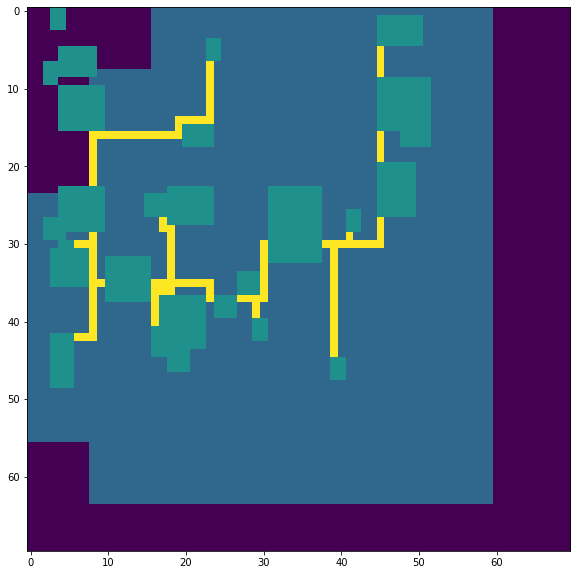

In [111]:

class Grid: # independent of city data
    def __init__(self, size, rectangles:dict={}):
        self.size = size # (x, y)
        self.rectangles = rectangles # {id: [x, y, length, height, "type"]}
        self.reset_all_cell_values()
        if len(rectangles) > 0:
            self.add_all_to_grid()
        
    # Initialize the grid with a negative value
    def reset_all_cell_values(self):
        self.grid = np.array([[-2 for _ in range(self.size[1])] for _ in range(self.size[0])])

    # general iterator over rectangle
    def rectangle_iterator(self, rectangle, function):
        pass
    
    # Iterate through the dictionary self.rectangles and "draw" them on the grid
    def set_all_cell_values(self):
        for key in self.rectangles:
            x, y, l, h, type = self.rectangles[key]
            for i in range(x, x+l):
                for j in range(y, y+h):
                    self.set_single_cell_value(i,j,type)
    
    # Sets the same value in the grid for a given rectangle...
    def set_cell_values_rectangle(self, rectangle):
        if isinstance(rectangle, Rectangle):
            x, y, l, h, type = self.rectangles[rectangle.id]
            for i in range(x, x+l):
                for j in range(y, y+h):
                    self.set_single_cell_value(i,j,type)
        #...or a list with coordinates and size
        elif isinstance(rectangle, list):
            x, y, l, h, type = rectangle
            for i in range(x, x+l):
                for j in range(y, y+h):
                    self.set_single_cell_value(i,j,type)
        else:
            print("unsupported type")
        
    # "draw" single square        
    def set_single_cell_value(self, x, y, value):
        self.grid[x, y] = value

    # retrieve type of certain square
    def get_cell_value(self, x, y):
        return self.grid[x][y]

    # actually draw grid
    def draw(self):
        plt.figure(figsize=(10,10))
        plt.imshow(self.grid)
        plt.show()
    
    # draw a new diagram with highlighted empty cells and returns their amount, CURRENTLY BREAKS THE GRID
    def highlight_empty(self):
        number_of_empty_cells = 0
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                if self.get_cell_value(j,i) == 0:
                    number_of_empty_cells += 1
                    self.set_single_cell_value(j,i,100+j+i)
        self.draw()
        return number_of_empty_cells
    
    # add rectangle object to dictionary self.rectangles    
    def add_to_grid(self, rectangle):
        # check for overlaps
        x, y, l, h, value = rectangle.x, rectangle.y, rectangle.length, rectangle.height, rectangle.value
        for i in range(x, x+l):
            for j in range(y, y+h):
                if self.get_cell_value(i,j) > 0:
                    print("Error: Overlap")
        self.rectangles[rectangle.id] = [x, y, l, h, value]
        self.set_cell_values_rectangle(rectangle)
    
    # given prior data, replace bad formatting of rectangles in-place
    def add_all_to_grid(self):
        for rectangle in self.rectangles.values():
            self.add_to_grid(rectangle)
        
    # creates new dictionary for buildings in the city without streets
    def remove_streets_and_patches(self):
        self.buildings = {}
        for key in self.rectangles:
            if self.rectangles[key][4] > 1:
                self.buildings[key] = [self.rectangles[key]]
        
    # returns true if adjacent cell is a street
    def is_connected(self, rectangle, draw:bool=False):
        y, x, height, width = rectangle[:4] # e.g. [8, 13, 4, 3, 5]
        isConnected = False
        for i in range(height): # checking for streets on vertical edges
            if self.get_cell_value(y+i, x-1) == 1 or self.get_cell_value(y+i, x+width) == 1:
                isConnected = True
                break
            if draw:
                self.set_single_cell_value(y+i, x-1, 99)
                self.set_single_cell_value(y+i, x+width, 99)
         
        if not isConnected:            
            for j in range(width): # checking for streets on horizontal edges
                if self.get_cell_value(y-1, x+j) == 1 or self.get_cell_value(y+height, x+j) == 1:
                    isConnected = True
                    break
                if draw:
                    self.set_single_cell_value(y-1, x+j, 99)
                    self.set_single_cell_value(y+height, x+j, 99)
                    
        return isConnected
    
    # shortestPathBinaryMatrix        
    def findPath(self, start_point, goalStates):
        if self.grid[start_point] == 1:
            print("stuck at start point")
        shortest_path = self.a_star_graph_search(
            start_point        = start_point, 
            goal_function      = self.get_goal_function(goalStates),
            successor_function = self.get_successor_function(),
            heuristic          = self.get_heuristic()
        )
        if shortest_path is None: 
            print("no path found")
            return -1
        else:
            for step in shortest_path:
                self.grid[step] = 4
            return (len(shortest_path),shortest_path)

    def a_star_graph_search(
                self,
                start_point,
                goal_function,
                successor_function,
                heuristic
        ):
        visited = set()
        came_from = dict()
        distance = {start_point: 0}
        frontier = PriorityQueue()
        frontier.add(start_point)
        while frontier:
            node = frontier.pop()
            if node in visited:
                continue
            if goal_function(node):
                return self.reconstruct_path(came_from, start_point, node)
            visited.add(node)
            for successor in successor_function(node):
                frontier.add(
                    successor,
                    priority = distance[node] + 1 + heuristic(successor)
                )
                if (successor not in distance
                    or distance[node] + 1 < distance[successor]):
                    distance[successor] = distance[node] + 1
                    came_from[successor] = node
        return None

    def reconstruct_path(self, came_from, start, end):
        """
        >>> came_from = {'b': 'a', 'c': 'a', 'd': 'c', 'e': 'd', 'f': 'd'}
        >>> reconstruct_path(came_from, 'a', 'e')
        ['a', 'c', 'd', 'e']
        """
        reverse_path = [end]
        while end != start:
            end = came_from[end]
            reverse_path.append(end)
        return list(reversed(reverse_path))    

    def get_goal_function(self, goalStates):
        """
        >>> f = get_goal_function([[0, 0], [0, 0]])
        >>> f((0, 0))
        False
        >>> f((0, 1))
        False
        >>> f((1, 1))
        True
        """
        # M = len(grid)
        # N = len(grid[0])
        # def is_bottom_right(cell):
        #     return cell == (M-1, N-1)
        # return is_bottom_right
        
        def is_in_goal_state(cell):
            return cell in goalStates
        return is_in_goal_state      
            
    def get_successor_function(self):
        """
        >>> f = get_successor_function([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
        >>> sorted(f((1, 2)))
        [(0, 1), (0, 2), (2, 1), (2, 2)]
        >>> sorted(f((2, 1)))
        [(1, 0), (1, 2), (2, 2)]
        """
        def get_clear_adjacent_cells(cell):
            i, j = cell
            return (
                (i + a, j + b)
                for a in (-1, 0, 1)
                for b in (-1, 0, 1)
                
                #if a != 0 or b != 0
                if np.abs(a) + np.abs(b) == 1
                
                if 0 <= i + a < len(self.grid)
                if 0 <= j + b < len(self.grid[0])
                if self.grid[i + a][j + b] == 0
            )
        return get_clear_adjacent_cells    
            
    def get_heuristic(self):
            """
            >>> f = get_heuristic([[0, 0], [0, 0]])
            >>> f((0, 0))
            1
            >>> f((0, 1))
            1
            >>> f((1, 1))
            0
            """
            M, N = len(self.grid), len(self.grid[0])
            (a, b) = goal_cell = (M - 1, N - 1)
            def get_clear_path_distance_from_goal(cell):
                (i, j) = cell
                return max(abs(a - i), abs(b - j))
            return get_clear_path_distance_from_goal
    
    # converts self.grid values to 2-3 different values in preparation for A* search
    def binarization(self, needs_connection_val): # very destructive method, overriding most building values
        for i in range(len(self.grid)):
            for j in range(len(self.grid[0])):
                if self.grid[i,j] <= 0: pass
                elif self.grid[i,j] == 1: self.grid[i,j] = 0
                elif self.grid[i,j] > 1: self.grid[i,j] = needs_connection_val
                else: print("undhandled cell value")
    
    # TODO WIP, maybe dismantle into more methods or implement NMSLIB, dijkstras A*
    def auto_solve(self):
        palaceton.binarization(0)
        for k in self.rectangles.keys():
            if self.rectangles[k][4] >= 4 and k<=250:        
                currbuilding = self.rectangles[k][2:4]
                
                # temporary rng, replace with closest road to new building
                rng = np.random.default_rng()
                rngX, rngY = rng.integers(0,50,(2))
                
                # change values on grid
                self.set_cell_values_rectangle([rngX,rngY,currbuilding[0],currbuilding[1],1])
                
                # make list of points in/around new building except for outer corners
                goalCoordinates = []
                for i in range(currbuilding[0]+2):
                    for j in range(currbuilding[1]+2):
                        a,b = rngX+i-1,rngY+j-1
                        if a >= 0 and b >= 0 and not (i == 0 and (j == 0 or j == currbuilding[1] + 1) or i == currbuilding[0] + 1 and (j == 0 or j == currbuilding[1] + 1)):
                            goalCoordinates.append((a,b))
                # print(goalCoordinates)
                
                # make list of points that are (considered) a road
                roads = []
                for i in range(self.size[0]):
                    for j in range(self.size[1]):
                        if self.get_cell_value(i,j) == 4:
                            roads.append((i,j))
                # print(len(roads),roads)
                
                # make list of points with distance from all roads to all goalStates
                distances = []
                for curr_road in roads:
                    for goalState in goalCoordinates:
                        dist = scipy.spatial.distance.cityblock(curr_road,goalState)
                        distances.append((dist,curr_road,goalState))
                # print(distances)
                
                # reduce the distances to just entries with min dist
                if distances: # checks if distances is empty
                    min_dist = min(d for d,_,__ in distances)
                    min_list = [(d,_,__) for d,_,__ in distances if d == min_dist]
                else:
                    min_list = [(0,(30,30),(30,30))]
                # print(min_list)
                
                
                # execution for single building           
                palaceton.findPath(min_list[0][1],goalCoordinates)
        
# takes a city map json as input and executes all necessary methods to convert it to useful data
def read_city_json(source_json:str):
    buildingDict = {}
    citymapdata = json.load(open(source_json, encoding="UTF-8")) # dict_keys(['CityMapData', 'CityEntities', 'UnlockedAreas']), len = 770, 1606, 205
    buildingType_keys = np.unique([entity["type"] for entity in citymapdata["CityEntities"].values()])
    """['clan_power_production' 'cultural_goods_production' 'culture'
    'decoration' 'diplomacy' 'friends_tavern' 'goods' 'greatbuilding'
    'hub_main' 'hub_part' 'impediment' 'main_building' 'military' 'off_grid'
    'outpost_ship' 'production' 'random_production' 'residential'
    'static_provider' 'street' 'tower']"""
    buildingType_values = [99,99,4,3,99,99,99,8,99,99,99,10,6,99,99,7,4,5,99,1,2] # 99 => off_grid or not used
    buildingType = dict(zip(buildingType_keys, buildingType_values))
    
    def _read_city_unlocked_areas():
        # reading CityMapData and creating grid with unlocked areas set to value "0"
        for patch in citymapdata["UnlockedAreas"]:
            patch.setdefault("y", 0)
            patch.setdefault("x", 0)
            tempRect = Rectangle(patch["y"], patch["x"], patch["width"], patch["length"], 0)
            buildingDict[tempRect.id] = tempRect
        
    def _read_city_entities():
        # reading CityMapData and creating a dictionary of currently available buildings
        for cityentity in citymapdata["CityEntities"].values():
            cityentity.setdefault("width", 0)
            cityentity.setdefault("length", 0)
        
    def _read_city_map_data():
        # reading CityMapData and adding each building to the grid
        for building in citymapdata["CityMapData"].values():
            building.setdefault("y", 0)
            building.setdefault("x", 0)
            buildingEntity = citymapdata["CityEntities"][building["cityentity_id"]]
            #print(buildingEntity)
            if re.match("W_MultiAge*", buildingEntity["id"]):
                size = buildingEntity["components"]["AllAge"]["placement"]["size"]
                width, length = size["x"], size["y"]
            else:
                width, length = buildingEntity["width"], buildingEntity["length"]
                
            if 0 <= building["y"] <= 70 and 0 <= building["x"] <= 70:
                tempRect = Rectangle(building["y"], building["x"], length, width, buildingType[buildingEntity["type"]])
                buildingDict[tempRect.id] = tempRect
            else: pass#print(building)
    
    _read_city_unlocked_areas()
    _read_city_entities()
    _read_city_map_data()
    return buildingDict
                
class Rectangle:
    RECTANGLEID = 1
    
    def __init__(self, x:int=0, y:int=0, length:int=0, height:int=0, value:int=-1):
        self.x, self.y, self.length, self.height, self.value = x,y,length,height,value
        self.id = Rectangle.RECTANGLEID
        Rectangle.RECTANGLEID += 1
    
class PriorityQueue:
    
    def __init__(self, iterable=[]):
        self.heap = []
        for value in iterable:
            heappush(self.heap, (0, value))
    
    def add(self, value, priority=0):
        heappush(self.heap, (priority, value))
    
    def pop(self):
        priority, value = heappop(self.heap)
        return value
    
    def __len__(self):
        return len(self.heap)





# Create a new grid
buildingDict = read_city_json("CityMapData.json")
palaceton = Grid((70,70),buildingDict)
palaceton.auto_solve()
palaceton.draw()

In [4]:
# class Solution:
    
#     def shortestPathBinaryMatrix(self, grid, startX, startY, endX, endY):
#         shortest_path = a_star_graph_search(
#             start              = (startX, startY), 
#             goal_function      = get_goal_function(grid, endX, endY),
#             successor_function = get_successor_function(grid),
#             heuristic          = get_heuristic(grid)
#         )
#         if shortest_path is None or grid[startX, startY] == 1:
#             return -1
#         else:
#             return (len(shortest_path),shortest_path)
        
# def a_star_graph_search(
#             start,
#             goal_function,
#             successor_function,
#             heuristic
#     ):
#     visited = set()
#     came_from = dict()
#     distance = {start: 0}
#     frontier = PriorityQueue()
#     frontier.add(start)
#     while frontier:
#         node = frontier.pop()
#         if node in visited:
#             continue
#         if goal_function(node):
#             return reconstruct_path(came_from, start, node)
#         visited.add(node)
#         for successor in successor_function(node):
#             frontier.add(
#                 successor,
#                 priority = distance[node] + 1 + heuristic(successor)
#             )
#             if (successor not in distance
#                 or distance[node] + 1 < distance[successor]):
#                 distance[successor] = distance[node] + 1
#                 came_from[successor] = node
#     return None

# def reconstruct_path(came_from, start, end):
#     """
#     >>> came_from = {'b': 'a', 'c': 'a', 'd': 'c', 'e': 'd', 'f': 'd'}
#     >>> reconstruct_path(came_from, 'a', 'e')
#     ['a', 'c', 'd', 'e']
#     """
#     reverse_path = [end]
#     while end != start:
#         end = came_from[end]
#         reverse_path.append(end)
#     return list(reversed(reverse_path))    

# def get_goal_function(grid, endX, endY):
#     """
#     >>> f = get_goal_function([[0, 0], [0, 0]])
#     >>> f((0, 0))
#     False
#     >>> f((0, 1))
#     False
#     >>> f((1, 1))
#     True
#     """
#     # M = len(grid)
#     # N = len(grid[0])
#     # def is_bottom_right(cell):
#     #     return cell == (M-1, N-1)
#     # return is_bottom_right
#     def isGoal(cell):
#         return cell == (endX, endY)
#     return isGoal
    
    
    
# def get_successor_function(grid):
#     """
#     >>> f = get_successor_function([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
#     >>> sorted(f((1, 2)))
#     [(0, 1), (0, 2), (2, 1), (2, 2)]
#     >>> sorted(f((2, 1)))
#     [(1, 0), (1, 2), (2, 2)]
#     """
#     def get_clear_adjacent_cells(cell):
#         i, j = cell
#         return (
#             (i + a, j + b)
#             for a in (-1, 0, 1)
#             for b in (-1, 0, 1)
            
#             #if a != 0 or b != 0
#             if np.abs(a) + np.abs(b) == 1
            
#             if 0 <= i + a < len(grid)
#             if 0 <= j + b < len(grid[0])
#             if grid[i + a][j + b] == 0
#         )
#     return get_clear_adjacent_cells    
    
# def get_heuristic(grid):
#     """
#     >>> f = get_heuristic([[0, 0], [0, 0]])
#     >>> f((0, 0))
#     1
#     >>> f((0, 1))
#     1
#     >>> f((1, 1))
#     0
#     """
#     M, N = len(grid), len(grid[0])
#     (a, b) = goal_cell = (M - 1, N - 1)
#     def get_clear_path_distance_from_goal(cell):
#         (i, j) = cell
#         return max(abs(a - i), abs(b - j))
#     return get_clear_path_distance_from_goal
        
# class PriorityQueue:
    
#     def __init__(self, iterable=[]):
#         self.heap = []
#         for value in iterable:
#             heappush(self.heap, (0, value))
    
#     def add(self, value, priority=0):
#         heappush(self.heap, (priority, value))
    
#     def pop(self):
#         priority, value = heappop(self.heap)
#         return value
    
#     def __len__(self):
#         return len(self.heap)